This Notebook will find optimal wieghts using MPT, then will back test those wieghts 1 year fowrad from data collections

In [1]:
import time
import os 

start_time = time.time() # measure run time

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
print(f'Current Working Directory: {os.getcwd()}')


Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py


Get Back Test Dates

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from utils.config import PROGRAM_START_DATE, PROGRAM_END_DATE, mpt_stocks_for_profit, mpt_stocks_for_sharpe
from utils.finance_utils import backtest_portfolio, MPTOptimizer, plot_cum_ret

date_obj = datetime.strptime(PROGRAM_END_DATE, "%Y-%m-%d")  # Convert string to datetime objectb
backtest_end = date_obj + relativedelta(years=1)

backtest_start = PROGRAM_END_DATE


Updated on 02/19/2025 11:28

---------------------------------
finance_utils.py successfully loaded, updated last Feb. 19 2025 10:42
---------------------------------




Conduct MPT

--MPT on High Profit--
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


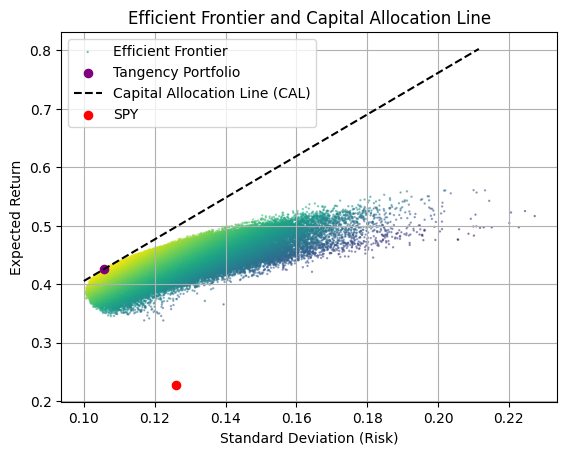

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

-- Optimal Portfolio (CAL) --
Max Sharpe Ratio: 3.56
Corresponding Return: 0.43
Corresponding Standard Deviation: 0.11
Optimal Weights: {'DECK': np.float64(0.055743430644141306), 'GE': np.float64(0.05870836720833841), 'K': np.float64(0.1585806345398562), 'WELL': np.float64(0.14555221109694932), 'PEG': np.float64(0.1880536572634871), 'MO': np.float64(0.08417680448794009), 'TMUS': np.float64(0.1755027080422423), 'NWG': np.float64(0.13368218671704524)}

--MPT on High Sharpe--


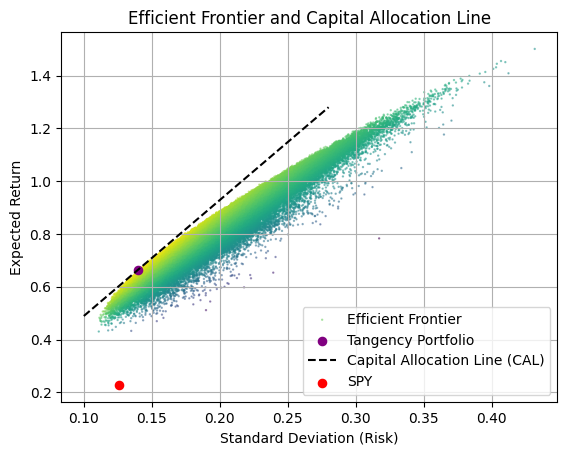

-- Optimal Portfolio (CAL) --
Max Sharpe Ratio: 4.4
Corresponding Return: 0.66
Corresponding Standard Deviation: 0.14
Optimal Weights: {'PEG': np.float64(0.06842880647049103), 'PLTR': np.float64(0.21701867040484568), 'MO': np.float64(0.20070022061387416), 'TCOM': np.float64(0.21493255392749627), 'APP': np.float64(0.1189071461324317), 'K': np.float64(0.07848321629246605), 'IBKR': np.float64(0.050988955910171434), 'NFLX': np.float64(0.05054043024822368)}


In [3]:
print('--MPT on High Profit--')
optimizer_for_high_profit = MPTOptimizer(mpt_stocks_for_profit, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
optimizer_for_high_profit.simulate_portfolios()
optimizer_for_high_profit.plot_efficient_frontier()
tangecy_portfolio_for_profit_stocks = optimizer_for_high_profit.find_tangency_portfolio()

print('\n--MPT on High Sharpe--')
optimizer_for_high_sharpe = MPTOptimizer(mpt_stocks_for_sharpe, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
optimizer_for_high_sharpe.simulate_portfolios()
optimizer_for_high_sharpe.plot_efficient_frontier()
tangecy_portfolio_for_sharpe_stocks = optimizer_for_high_sharpe.find_tangency_portfolio()


In [4]:
import datetime

program_start_date_obj = datetime.datetime.strptime(backtest_start, '%Y-%m-%d')

# Check if the year is less than 2021
if program_start_date_obj.year < 2021:
    print("Will need to use IRX")
    risk_rate_ticker = '^IRX'
else:
    print("we can use sgov")
    risk_rate_ticker = 'SGOV'

we can use sgov


In [5]:
from utils.finance_utils import find_lending_or_borrowing_portfolio


# Benchmark Metrics
spy_return = optimizer_for_high_profit.spy_return.iloc[0]
spy_std = optimizer_for_high_profit.spy_std.iloc[0]
risk_free_rate = optimizer_for_high_profit.risk_free_rate.iloc[0] # Optimizer uses mean rate

# Info for high profit stocks
stock_weight_dict_profit = tangecy_portfolio_for_profit_stocks[0]
tangecy_portfolio_metrics_dict_profit = tangecy_portfolio_for_profit_stocks[1]

# Info for high profit stocks
stock_weight_dict_sharpe = tangecy_portfolio_for_sharpe_stocks[0]
tangecy_portfolio_metrics_dict_sharpe = tangecy_portfolio_for_sharpe_stocks[1]


# Find lending or borrowing for 
portfolio_allocation_high_profit = find_lending_or_borrowing_portfolio(
    tangecy_portfolio_metrics_dict_profit['Corresponding Return'],
    tangecy_portfolio_metrics_dict_profit['Corresponding Standard Deviation'],
    risk_free_rate,
    spy_std,
    list(stock_weight_dict_profit.keys()),
    list(stock_weight_dict_profit.values()),
    add_margin=True,
    risk_free_proxy=risk_rate_ticker
    )

portfolio_allocation_high_sharpe = find_lending_or_borrowing_portfolio(
    tangecy_portfolio_metrics_dict_sharpe['Corresponding Return'],
    tangecy_portfolio_metrics_dict_sharpe['Corresponding Standard Deviation'],
    risk_free_rate,
    spy_std,
    list(stock_weight_dict_sharpe.keys()),
    list(stock_weight_dict_sharpe.values()),
    add_margin=True,
    risk_free_proxy=risk_rate_ticker
    )

Begin Back Testing

[*********************100%***********************]  1 of 1 completed

----Begining Back Test----
Back Test starts on: 2025-01-01
Back Test ends on: 2026-01-01 00:00:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

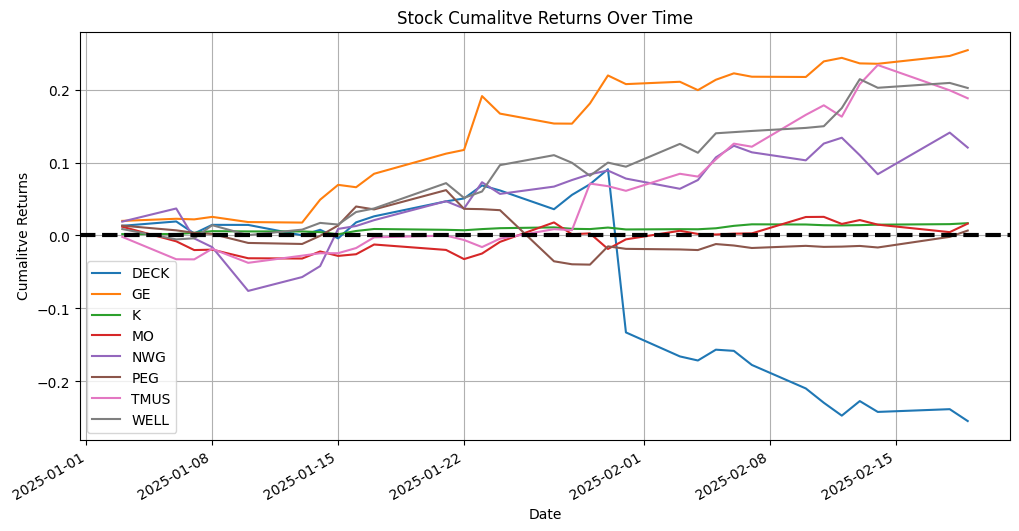

[*********************100%***********************]  8 of 8 completed


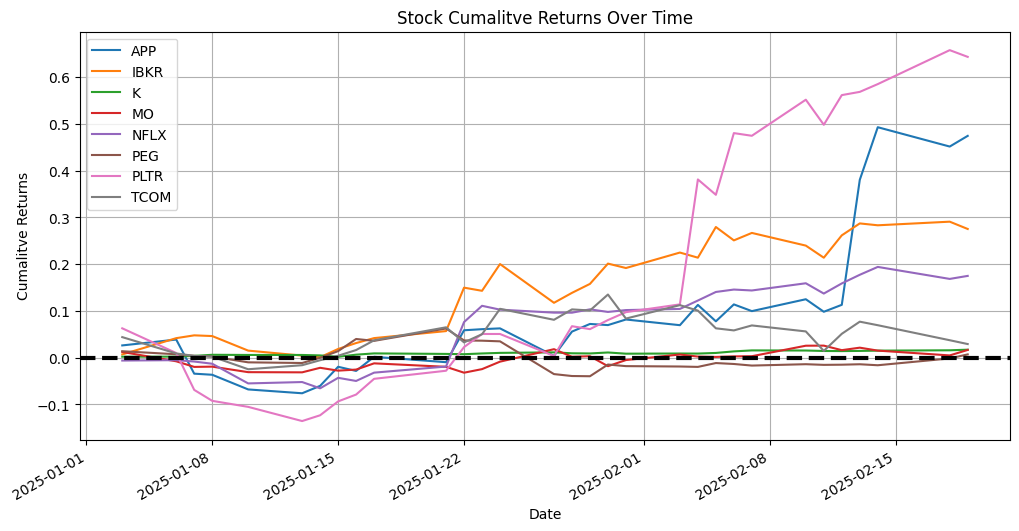

In [6]:

print('----Begining Back Test----')
print(f'Back Test starts on: {backtest_start}')
print(f'Back Test ends on: {backtest_end}')

paper_value = 100_000


# Run the backtest
backtest_on_high_profit = backtest_portfolio(portfolio_allocation_high_profit['Stocks'], paper_value, portfolio_allocation_high_profit['Stock Weights'], start_date=backtest_start, end_date=backtest_end)
backtest_on_high_sharpe = backtest_portfolio(portfolio_allocation_high_sharpe['Stocks'], paper_value, portfolio_allocation_high_sharpe['Stock Weights'], start_date=backtest_start, end_date=backtest_end)
plot_cum_ret(mpt_stocks_for_profit,  start_date=backtest_start, end_date=backtest_end)
plot_cum_ret(mpt_stocks_for_sharpe, start_date=backtest_start, end_date=backtest_end)

Record Results

In [7]:
import pandas as pd
import os

# Define file path
file_path = f"{WORKSPACE_DIR}/portfolio_py/data/clean/backtest_results.csv"

# Check if file exists
if os.path.exists(file_path):
    # Load existing data
    backtest_df = pd.read_csv(file_path)
else:
    # Create a new DataFrame if the file doesn't exist
    backtest_df = pd.DataFrame(columns=[
        "Data_Collection_Start", "Data_Collection_End",
        "Backtest_Start", "Backtest_End",
        "Stock_Selection_Method", 'Stocks', 'Sharpe', "Starting_Value", "Ending_Value"
    ])

# New entries to append
new_entries = [
    {
        "Data_Collection_Start": PROGRAM_START_DATE,
        "Data_Collection_End": PROGRAM_END_DATE,
        "Backtest_Start": backtest_start,
        "Backtest_End": backtest_end,
        "Stock_Selection_Method": "High Profit Stocks",
        "Stocks": (",".join(portfolio_allocation_high_profit['Stocks'])),
        'Sharpe': tangecy_portfolio_for_profit_stocks[1]['Max Sharpe'],
        "Starting_Value": paper_value,
        "Ending_Value": backtest_on_high_profit,
        'SPY Retrun': spy_return
    },
    {
        "Data_Collection_Start": PROGRAM_START_DATE,
        "Data_Collection_End": PROGRAM_END_DATE,
        "Backtest_Start": backtest_start,
        "Backtest_End": backtest_end,
        "Stock_Selection_Method": "High Sharpe Ratio Stocks",
        "Stocks": (",".join(portfolio_allocation_high_sharpe['Stocks'])),
        'Sharpe': tangecy_portfolio_for_sharpe_stocks[1]['Max Sharpe'],
        "Starting_Value": paper_value,
        "Ending_Value": backtest_on_high_sharpe,
        'SPY Retrun': spy_return

    }
]

# Convert new entries to a DataFrame
new_entries_df = pd.DataFrame(new_entries)

# Drop duplicates before writing
backtest_df = pd.concat([backtest_df, new_entries_df], ignore_index=True).drop_duplicates()

# **Append** to the CSV without overwriting
backtest_df.to_csv(file_path, index=False, mode="w")  

print("New rows added successfully (without overwriting)!") 


New rows added successfully (without overwriting)!


In [8]:
backtest_df

,Data_Collection_Start,Data_Collection_End,Backtest_Start,Backtest_End,Stock_Selection_Method,Stocks,Sharpe,Starting_Value,Ending_Value,SPY Retrun
0,2016-01-01,2017-01-01,2017-01-01,2018-01-01,High Profit Stocks,"TOELY,TRP,MTB,ASML,IDXX,JPM,ITUB,EOG,^IRX",2.494917,100000,111924.404855,NaN
1,2016-01-01,2017-01-01,2017-01-01,2018-01-01,High Sharpe Ratio Stocks,"TOELY,TRP,BRK-B,ASML,IDXX,BMO,EOG,ITUB,^IRX",2.495090,100000,119298.073579,NaN
2,2017-01-01,2018-01-01,2018-01-01,2019-01-01 00:00:00,High Profit Stocks,"DHI,V,ABT,ISRG,CAT,MCD,^IRX",5.246875,100000,101331.829539,NaN
3,2017-01-01,2018-01-01,2018-01-01,2019-01-01 00:00:00,High Sharpe Ratio Stocks,"DHI,V,ABT,ISRG,CAT,MCD,^IRX",5.246343,100000,101331.925659,NaN
4,2017-01-01,2018-01-01,2018-01-01,2019-01-01 00:00:00,High Profit Stocks,"DHI,V,ABT,ISRG,CAT,MCD,^IRX",5.247479,100000,101056.001452,0.188812
5,2017-01-01,2018-01-01,2018-01-01,2019-01-01 00:00:00,High Sharpe Ratio Stocks,"DHI,V,ABT,ISRG,CAT,MCD,^IRX",5.244081,100000,100861.064764,0.188812
6,2018-01-01,2019-01-01,2019-01-01,2020-01-01 00:00:00,High Profit Stocks,"AXON,MRK,ISRG,MA,NFLX,OLCLY,V,MSCI,^IRX",1.553746,100000,146987.843376,-0.053899
7,2018-01-01,2019-01-01,2019-01-01,2020-01-01 00:00:00,High Sharpe Ratio Stocks,"AXON,MRK,MA,ORLY,NFLX,NOW,AJG,MSCI,^IRX",1.722982,100000,143559.157224,-0.053899
8,2019-01-01,2020-01-01,2020-01-01,2021-01-01 00:00:00,High Profit Stocks,"ASML,TRP,MA,APD,MSCI,URI,ACGL,LULU,^IRX",3.649237,100000,124956.077247,0.270695
9,2019-01-01,2020-01-01,2020-01-01,2021-01-01 00:00:00,High Sharpe Ratio Stocks,"ASML,BX,TRP,APD,APO,URI,ACGL,LULU,^IRX",3.769222,100000,110016.964324,0.270695
